# Load Data

In [1]:
import pandas as pd

data = pd.read_csv("netflix_titles.csv")
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
data.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

# Text Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Combine relevant info
data['text_representation'] = data['listed_in'] + ' ' + data['description']

# Fit TF-IDF and transform to sparse matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['text_representation'])

# Sparse matrix can't be used as input for neural net; convert to numpy array
tfidf_matrix_dense = tfidf_matrix.toarray()
X_train, X_test = train_test_split(tfidf_matrix_dense, test_size=0.2, random_state=42)

print(tfidf_matrix[0])

  (0, 8490)	0.3343968649216488
  (0, 6082)	0.19901300008553238
  (0, 7801)	0.16337546298647904
  (0, 18310)	0.22546933050146495
  (0, 3464)	0.3085992782573314
  (0, 8758)	0.3085992782573314
  (0, 4344)	0.18019746807827544
  (0, 15937)	0.2770645038300997
  (0, 9031)	0.31538493113752597
  (0, 9347)	0.34948748572937866
  (0, 6376)	0.22751854806078578
  (0, 9766)	0.12494777897557835
  (0, 5596)	0.22228636194461462
  (0, 11313)	0.302862090494417
  (0, 6209)	0.16130387477651925
  (0, 5008)	0.12328949072223687


# Autoencoder

In [27]:
import tensorflow as tf
from keras import models, layers, Input

input_dim = X_train.shape[1]
encoding_dim = 128

# Define autoencoder architecture
autoencoder = models.Sequential([
    Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

input_dim

18895

In [5]:
from keras import callbacks

tf.keras.backend.clear_session()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Fit autoencoder; stop early if validation loss is not improving
cb = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
    )
]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=cb)

# Extract encoder part, leaving out decoder
encoder = models.Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.layers[0].output)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.6887 - val_loss: 0.6537
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.6014 - val_loss: 0.3570
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.2619 - val_loss: 0.0857
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0597 - val_loss: 0.0299
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0226 - val_loss: 0.0170
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/ste

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_encoder(title, data=data, encoder=encoder):
    idx = data[data['title'] == title].index[0]
    input_vector = tfidf_matrix_dense[idx]
    
    encoded_input = encoder.predict(input_vector.reshape(1, -1))    
    similarity_scores = cosine_similarity(encoded_input, encoder.predict(tfidf_matrix_dense))
    
    # Sort scores and get indices of top 10 scores
    similar_indices = similarity_scores.argsort()[0][-11:-1]
    
    return data.iloc[similar_indices]['title']

In [7]:
recommendations = recommend_encoder("Breaking Bad")
recommendations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


4773                  How It Ends
6741                Fatal Destiny
1834                     Start-Up
2670                      Hasmukh
4495           Marvel's Daredevil
4310                    Travelers
6228            Bangkok Bachelors
8021     Sin senos no hay paraíso
1559    The Mess You Leave Behind
2400                   The Search
Name: title, dtype: object

In [8]:
print(data[data['title'] == "Breaking Bad"].iloc[0].listed_in)
print(data[data['title'] == "Breaking Bad"].iloc[0].description)

Crime TV Shows, TV Dramas, TV Thrillers
A high school chemistry teacher dying of cancer teams with a former student to secure his family's future by manufacturing and selling crystal meth.


In [9]:
for movie in recommendations:
    print("Title:", data[data['title'] == movie].iloc[0].title)
    print("Listed in:", data[data['title'] == movie].iloc[0].listed_in)
    print("Description:", data[data['title'] == movie].iloc[0].description)
    print()

Title: How It Ends
Listed in: Action & Adventure, Sci-Fi & Fantasy
Description: When a mysterious disaster turns the country into a war zone, a young lawyer heads west with his future father-in-law to find his pregnant fiancée.

Title: Fatal Destiny
Listed in: Crime TV Shows, International TV Shows, TV Action & Adventure
Description: A young man from a humble family is drawn into a life of crime – and soon confronts a determined cop in hot pursuit.

Title: Start-Up
Listed in: International TV Shows, Romantic TV Shows, TV Comedies
Description: Young entrepreneurs aspiring to launch virtual dreams into reality compete for success and love in the cutthroat world of Korea's high-tech industry.

Title: Hasmukh
Listed in: Crime TV Shows, International TV Shows, TV Comedies
Description: A timid, small-town comedian's long-awaited big break takes a dark turn when he realizes committing murder is the only way to keep his onstage mojo.

Title: Marvel's Daredevil
Listed in: Crime TV Shows, TV Act

# K-Means

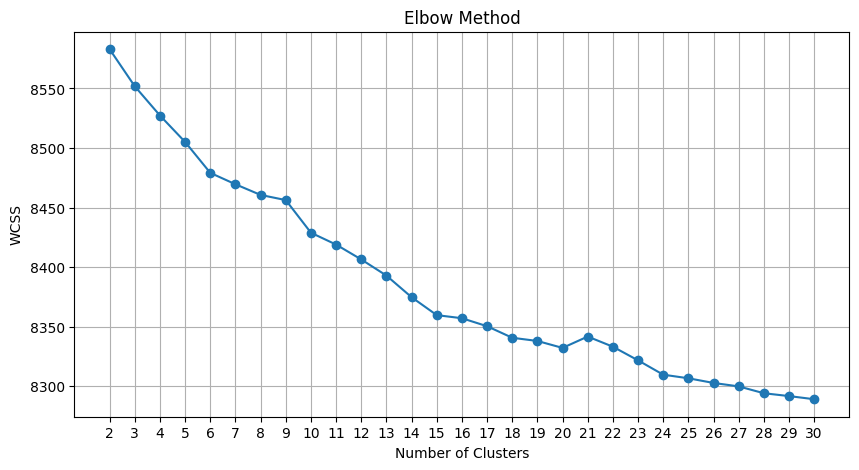

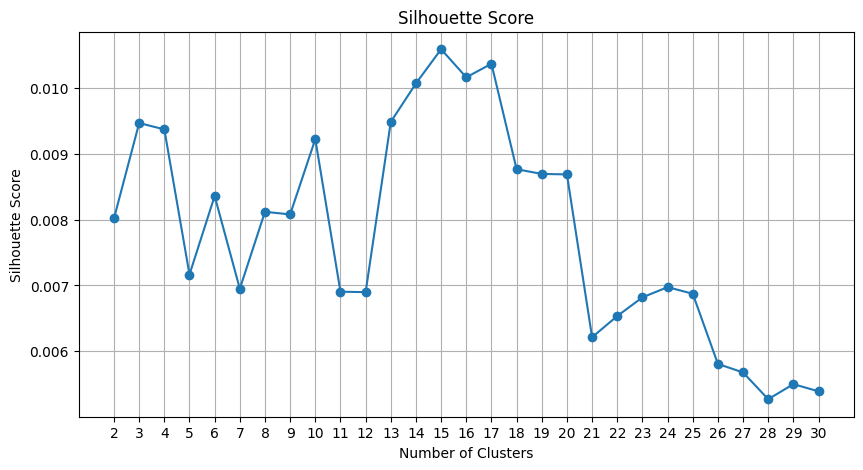

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []  # Values for elbow curve
silhouette_scores = []
max_k = 30
k_range = range(2, max_k + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [11]:
# Perform K-Means clustering
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)

data['cluster_label'] = kmeans.labels_

In [30]:
for i, movie in data[data['cluster_label'] == 9].head(n=10).iterrows():
    print("Title:", movie.title)
    print("Listed in:", movie.listed_in)
    print("Description:", movie.description)
    print()

Title: Ganglands
Listed in: Crime TV Shows, International TV Shows, TV Action & Adventure
Description: To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.

Title: Vendetta: Truth, Lies and The Mafia
Listed in: Crime TV Shows, Docuseries, International TV Shows
Description: Sicily boasts a bold "Anti-Mafia" coalition. But what happens when those trying to bring down organized crime are accused of being criminals themselves?

Title: Bangkok Breaking
Listed in: Crime TV Shows, International TV Shows, TV Action & Adventure
Description: Struggling to earn a living in Bangkok, a man joins an emergency rescue service and realizes he must unravel a citywide conspiracy.

Title: Crime Stories: India Detectives
Listed in: British TV Shows, Crime TV Shows, Docuseries
Description: Cameras following Bengaluru police on the job offer a rare glimpse into the complex and challenging inner workings of four maj

In [34]:
def recommend_kmeans(title, data=data, tfidf_matrix=tfidf_matrix):
    idx = data[data['title'] == title].index[0]
    cluster_label = data.iloc[idx]['cluster_label']
    print("Cluster label:", cluster_label)
    
    # Filter movies in the same cluster
    cluster_movies = data[data['cluster_label'] == cluster_label]
    
    similarity_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix[cluster_movies.index])
    
    # Sort scores and get indices of top 10 scores
    similar_movie_indices = similarity_scores.argsort()[0][-11:-1]
    
    return data.iloc[cluster_movies.index[similar_movie_indices]]['title']

In [35]:
recommendations = recommend_kmeans("Breaking Bad")
recommendations

Cluster label: 9


4636                              American Vandal
6841                                   Get Shorty
679                                 The Judgement
385               How to Sell Drugs Online (Fast)
3361                                       Tunnel
4664                             Age of Rebellion
3855                                   The Writer
4143                                       Sparta
5352    Have You Ever Fallen in Love, Miss Jiang?
2606                              Extracurricular
Name: title, dtype: object

In [14]:
print(data[data['title'] == "Breaking Bad"].iloc[0].listed_in)
print(data[data['title'] == "Breaking Bad"].iloc[0].description)

Crime TV Shows, TV Dramas, TV Thrillers
A high school chemistry teacher dying of cancer teams with a former student to secure his family's future by manufacturing and selling crystal meth.


In [38]:
for movie in recommendations:
    print("Title:", data[data['title'] == movie].iloc[0].title)
    print("Listed in:", data[data['title'] == movie].iloc[0].listed_in)
    print("Description:", data[data['title'] == movie].iloc[0].description)
    print()

Title: American Vandal
Listed in: Crime TV Shows, TV Comedies, Teen TV Shows
Description: A high school is rocked by an act of vandalism, but the top suspect pleads innocence and finds an ally in a filmmaker. A satirical true crime mystery.

Title: Get Shorty
Listed in: Crime TV Shows, TV Comedies, TV Dramas
Description: Organized crime enforcer Miles Daly strives to reinvent himself as a Hollywood filmmaker in this satire based on Elmore Leonard's best-selling novel.

Title: The Judgement
Listed in: Crime TV Shows, International TV Shows, TV Dramas
Description: After a traumatic incident at a party makes her a target of gossip and derision, a young college student tries to change her school's toxic culture.

Title: How to Sell Drugs Online (Fast)
Listed in: Crime TV Shows, International TV Shows, TV Comedies
Description: To win back his ex-girlfriend, a nerdy teen starts selling ecstasy online out of his bedroom – and becomes one of Europe's biggest dealers.

Title: Tunnel
Listed in: 